In [2]:
# importar las librerías que necesarias

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Cargar los datos que vamos a usar 

df = pd.read_csv("dados/digital_campaign_savings_account.csv", index_col = 0)
df.head(10)

,channel,sessions,unique_users,conversions,conversion_rate,spent,clicks
date,,,,,,,
2024-01-01,Web,2070,1750,88,0.0503,5352.48,648
2024-01-01,App,931,798,70,0.0884,2806.90,518
2024-01-01,Redes Sociales,4125,2446,83,0.0341,12746.98,966
2024-01-01,Email,1684,909,104,0.1149,7340.61,516
2024-01-01,SEO,1269,1256,12,0.0103,7213.24,1005
2024-01-01,Paid Ads,922,732,15,0.0207,13194.74,390
2024-01-02,Web,4738,2883,173,0.0601,14241.56,984
2024-01-02,App,4664,3209,320,0.0999,2100.87,1780
2024-01-02,Redes Sociales,1987,1951,50,0.0259,12949.83,908


Informaciones genericas de los datos utilizados

In [41]:
# ¿Cuántas filas y columnas tenemos en el dataframe?

print(f'El datadrame tiene {df.shape[0]} filas y {df.shape[1]} columnas.')

El datadrame tiene 360 filas y 7 columnas.


In [42]:
# ¿Cuáles son los tipos de los datos de cada columna del dataframe?

print(f"Las columnas del DataFrame son: \n {df.dtypes}")

Las columnas del DataFrame son: 
 channel             object
sessions             int64
unique_users         int64
conversions          int64
conversion_rate    float64
spent              float64
clicks               int64
dtype: object


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 2024-01-01 to 2024-02-29
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   channel          360 non-null    object 
 1   sessions         360 non-null    int64  
 2   unique_users     360 non-null    int64  
 3   conversions      360 non-null    int64  
 4   conversion_rate  360 non-null    float64
 5   spent            360 non-null    float64
 6   clicks           360 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 22.5+ KB


In [45]:
# Muestra los principales estadísticos para las columnas numéricas del dataframe

df.describe().T

,count,mean,std,min,25%,50%,75%,max
sessions,360.0,2639.536111,1297.206495,526.0000,1534.50000,2606.50000,3765.250000,4952.0000
unique_users,360.0,1944.363889,1028.570890,280.0000,1049.00000,1838.00000,2648.500000,4657.0000
conversions,360.0,126.955556,130.805745,5.0000,43.75000,84.50000,156.250000,764.0000
conversion_rate,360.0,0.064187,0.047626,0.0103,0.02935,0.04805,0.084725,0.1991
spent,360.0,8038.518000,4390.058753,540.5300,4427.13750,8056.54000,12165.085000,14950.0200
clicks,360.0,1274.102778,810.282830,91.0000,617.25000,1100.00000,1749.750000,3773.0000


In [46]:
# Muestra los principales estadísticos para las columnas categoricas del dataframe

df_cat = df.select_dtypes(include="object")
df_cat.head(2)

# creamos una variable con los nombres de las columnas del DataFrame de las variables categóricas utilizando el método '.columns'
columnas_cat = df_cat.columns
print(f"Las columnas del DataFrame de variables categóricas son {columnas_cat}")

# empezamos a iterar por cada una de las columnas para sacar principales estadisticos
for columna in columnas_cat:
    print(f" \n----------- ESTAMOS ANALIZANDO LA COLUMNA: '{columna.upper()}' -----------\n")
    print(f"Sus valores únicos son: {df_cat[columna].unique()}\n")
    print(f"Las frecuencias de los valores únicos de las categorías son: {df_cat[columna].value_counts()} ")

Las columnas del DataFrame de variables categóricas son Index(['channel'], dtype='object')
 
----------- ESTAMOS ANALIZANDO LA COLUMNA: 'CHANNEL' -----------

Sus valores únicos son: ['Web' 'App' 'Redes Sociales' 'Email' 'SEO' 'Paid Ads']

Las frecuencias de los valores únicos de las categorías son: channel
Web               60
App               60
Redes Sociales    60
Email             60
SEO               60
Paid Ads          60
Name: count, dtype: int64 


In [47]:
# Calcular la media de la tasa de conversión por canal
media_conversion = df.groupby("channel")["conversion_rate"].mean()

print(media_conversion)

channel
App               0.085972
Email             0.152615
Paid Ads          0.040197
Redes Sociales    0.035145
SEO               0.018863
Web               0.052330
Name: conversion_rate, dtype: float64


In [48]:
def resumen_por_canal(df):
    """
    Devuelve un resumen estadístico de cada variable por canal.
    
    Parámetros:
    - df (DataFrame): DataFrame con los datos de la campaña.
    
    Retorna:
    - DataFrame con estadísticas descriptivas por canal.
    """
    resumen = df.groupby("channel").agg({
        "sessions": ["mean", "sum", "max", "min"],
        "conversions": ["mean", "sum", "max", "min"],
        "conversion_rate": ["mean"],
        "spent": ["mean", "sum"],
        "clicks": ["mean", "sum"]
    })
    
    return resumen

# Llamar a la función con el DataFrame ya cargado
resumen = resumen_por_canal(df)
print(resumen)

                   sessions                    conversions                  \
                       mean     sum   max  min        mean    sum  max min   
channel                                                                      
App             2677.950000  160677  4860  646  176.016667  10561  519  24   
Email           2657.966667  159478  4871  538  307.250000  18435  764  52   
Paid Ads        2406.466667  144388  4919  730   70.200000   4212  226  11   
Redes Sociales  2731.316667  163879  4835  536   69.066667   4144  180  12   
SEO             2588.083333  155285  4952  555   34.033333   2042   83   5   
Web             2775.433333  166526  4849  526  105.166667   6310  304  14   

               conversion_rate        spent                  clicks         
                          mean         mean        sum         mean    sum  
channel                                                                     
App                   0.085972  7366.644000  441998.64  1307.60000

In [49]:
display(resumen)

sessions                    conversions                  \
                       mean     sum   max  min        mean    sum  max min   
channel                                                                      
App             2677.950000  160677  4860  646  176.016667  10561  519  24   
Email           2657.966667  159478  4871  538  307.250000  18435  764  52   
Paid Ads        2406.466667  144388  4919  730   70.200000   4212  226  11   
Redes Sociales  2731.316667  163879  4835  536   69.066667   4144  180  12   
SEO             2588.083333  155285  4952  555   34.033333   2042   83   5   
Web             2775.433333  166526  4849  526  105.166667   6310  304  14   

               conversion_rate        spent                  clicks         
                          mean         mean        sum         mean    sum  
channel                                                                     
App                   0.085972  7366.644000  441998.64  1307.600000  78456  
Email                 0.152615  8034.431833  482065.91  1265.883333  75953  
Paid Ads              0.040197  7893.007500  473580.45  1124.483333  67469  
Redes Sociales        0.035145  8646.662167  518799.73  1337.616667  80257  
SEO                   0.018863  7859.026500  471541.59  1340.566667  80434  
Web                   0.052330  8431.336000  505880.16  1268.466667  76108

Validaciones para asegurar que el dataset es consistente:

In [44]:
# ¿Tenemos filas duplicadas en el dataframe ?

print(f'Filas duplicadas = {df.duplicated().sum()}')

Filas duplicadas = 0


In [51]:
def sessions_vs_users(df):
    """Asegura que las sesiones sean siempre mayores que los usuarios únicos."""
    invalid_rows = df[df['sessions'] < df['unique_users']]
    if not invalid_rows.empty:
        print("⚠️ Hay filas donde sessions < unique_users. Revisa:")
        print(invalid_rows)
    else:
        print("✅ Todas las sesiones son mayores que los usuarios únicos.")

In [52]:
def validate_conversion_rate(df):
    """Asegura que la tasa de conversión está entre 0 y 1."""
    invalid_rows = df[(df['conversion_rate'] < 0) | (df['conversion_rate'] > 1)]
    if not invalid_rows.empty:
        print("⚠️ Hay tasas de conversión fuera del rango [0,1]. Revisa:")
        print(invalid_rows)
    else:
        print("✅ Todas las tasas de conversión están en el rango correcto.")

In [53]:
def run_validations(df):
    """Ejecuta todas las validaciones sobre el dataset."""
    print("--- Iniciando validaciones ---")
    sessions_vs_users(df)
    validate_conversion_rate(df)
    print("--- Validaciones completadas ---")

In [54]:
run_validations(df)

--- Iniciando validaciones ---
✅ Todas las sesiones son mayores que los usuarios únicos.
✅ Todas las tasas de conversión están en el rango correcto.
--- Validaciones completadas ---


Visualización:

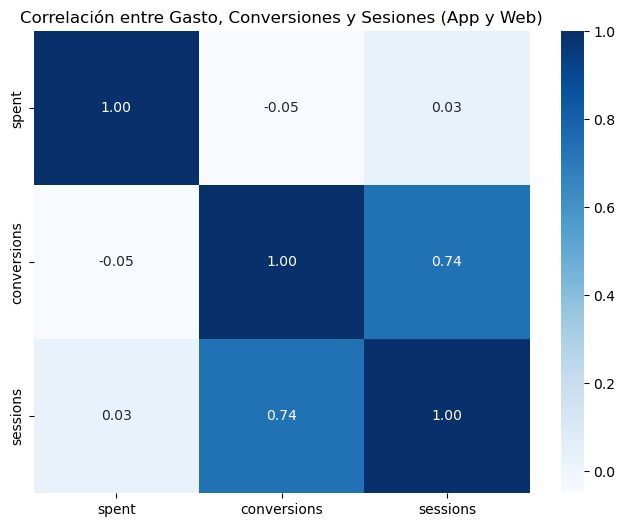

In [15]:
def plot_correlation_chart(df):
        
    # Filtrar solo los canales 'App' y 'Web'
    df_filtered = df[df['channel'].isin(['App', 'Web'])]
    
    # Seleccionar las columnas de interés
    df_corr = df_filtered[['spent', 'conversions', 'sessions']]
    
    # Calcular la matriz de correlación
    correlation_matrix = df_corr.corr()
    
    
    # Crear el gráfico de calor con Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
    plt.title('Correlación entre Gasto, Conversiones y Sesiones (App y Web)')
    plt.show()

# Llamar la función con el archivo cargado
plot_correlation_chart(df)


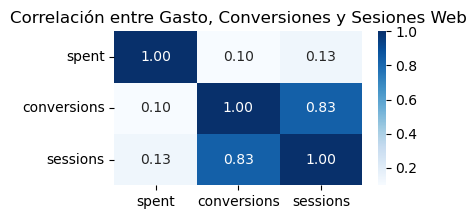

In [31]:
def plot_correlation_chart(df,channel):
        
    # Filtrar solo los canales 'App' y 'Web'
    df_filtered = df[df['channel'].isin([channel])]
    
    # Seleccionar las columnas de interés
    df_corr = df_filtered[['spent', 'conversions', 'sessions']]
    
    # Calcular la matriz de correlación
    correlation_matrix = df_corr.corr()
    
    # creamos una matriz booleana de máscara
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    
    # Crear el gráfico de calor con Seaborn
    plt.figure(figsize=(4, 2))
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
    plt.title (f'Correlación entre Gasto, Conversiones y Sesiones {channel}')
    plt.show()

# Llamar la función con el archivo cargado
plot_correlation_chart(df,'Web')


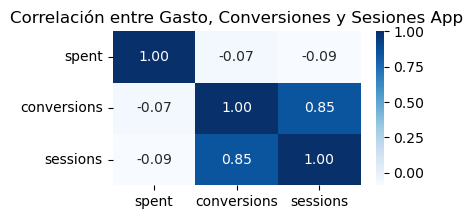

In [32]:
plot_correlation_chart(df,'App')